<center><h1>Visual Question Answering (VQA)</h1></center>

In [0]:
#installing packages (since i'm using google colab,i'm installing from notebook itself)

#%%capture
#!pip3 install --upgrade tensorflow-gpu
#!pip install tensorflow --upgrade

In [0]:
#importing packages
import warnings
warnings.filterwarnings("ignore")

import pickle
import os
import pandas as pd
import random as rn
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.regularizers import l1,l2
from tqdm import tqdm
import heapq
from sklearn.utils import shuffle
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


<h1>Mounting the Drive </h1>

In [0]:
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


<h1>Variables</h1>

In [0]:
currentDirectory = "/content/drive/My Drive/pcase_study_2/"
os.chdir(currentDirectory)
currentDirectory = ""
dataDirectory = currentDirectory + "data/"
imageDirectory = dataDirectory + "train2014/"
imageNumpyDirectory = dataDirectory + "train2014_Numpy/"
modelsDirectory = currentDirectory + "Models/"
img_width = 224
img_height = 224

BATCH_SIZE = 64
BUFFER_SIZE = 300

In [0]:
#len(os.listdir(imageNumpyDirectory))
data = pd.read_csv(dataDirectory + 'data.csv')
X_train, X_val = train_test_split(data, test_size=0.2, random_state=42)

# <h1>1. Creating Answer Vectors </h1>

In [0]:
contractions = { 
"ain't": "am not","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will","he's": "he is","how'd": "how did",
"how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
"it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"must've": "must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not","she'd": "she would",
"she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are","what's": "what is",
"what've": "what have","where'd": "where did","where's": "where is","who'll": "who will","who's": "who is","won't": "will not","wouldn't": "would not",
"you'd": "you would","you'll": "you will","you're": "you are"
}

def preprocess_english(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = ""
    text = text.lower()
    i = 0
    for word in text.split():
      if i==0:
        new_text = contractions.get(word,word)
      else:
        new_text = new_text + " " + contractions.get(word,word)
      i += 1
    return new_text.replace("'s", '')

In [0]:
X_train['multiple_choice_answer'] = X_train['multiple_choice_answer'].apply(lambda x: preprocess_english(x))
X_val['multiple_choice_answer'] = X_val['multiple_choice_answer'].apply(lambda x: preprocess_english(x))

In [0]:
all_classes = X_train['multiple_choice_answer'].values
class_frequency = {}

for _cls in all_classes:
    if(class_frequency.get(_cls,-1)>0):
        class_frequency[_cls] += 1
    else:
        class_frequency[_cls] = 1

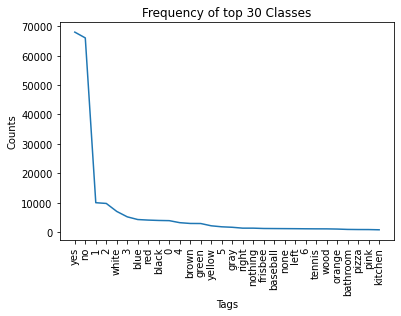

In [0]:
sort_class_frequency = sorted(list(class_frequency.items()),key = lambda x: x[1],reverse=True)   

plt.plot([x[1] for x in sort_class_frequency[:30]])
i=np.arange(30)
plt.title("Frequency of top 30 Classes")
plt.xlabel("Tags")
plt.ylabel("Counts")
plt.xticks(i,[x[0] for x in sort_class_frequency[:30]])
plt.xticks(rotation=90)
plt.show()

5 most frequent Classes covers 45.32% points
10 most frequent Classes covers 51.46% points
20 most frequent Classes covers 57.25% points
50 most frequent Classes covers 64.02% points
70 most frequent Classes covers 66.62% points
100 most frequent Classes covers 69.50% points
200 most frequent Classes covers 75.35% points
500 most frequent Classes covers 82.89% points
750 most frequent Classes covers 85.69% points
1000 most frequent Classes covers 87.51% points
2000 most frequent Classes covers 91.27% points
3000 most frequent Classes covers 93.13% points
5000 most frequent Classes covers 95.17% points


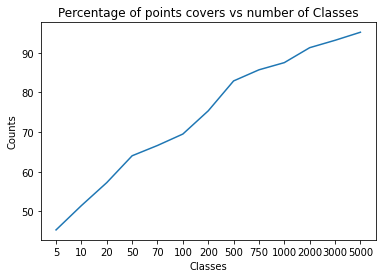

In [0]:
def getPercentageOfDataCoversGivenNumClasses(n_class, class_frequency, df):
    n_common_class = heapq.nlargest(n_class, class_frequency, key=class_frequency.get)
    count = 0
    for _class in df['multiple_choice_answer'].values:
        if(_class in n_common_class):
            count += 1

    return (count/len(df))*100
    
n_classes = [5,10,20,50,70,100,200,500,750,1000,2000,3000,5000]
percentage_cover = []
for i in n_classes:
    temp = getPercentageOfDataCoversGivenNumClasses(i,class_frequency,X_train)
    percentage_cover.append(temp)
    print("{} most frequent Classes covers {:.2f}% points".format(i,temp))


plt.plot(percentage_cover)
i=np.arange(len(percentage_cover))
plt.title("Percentage of points covers vs number of Classes")
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.xticks(i,n_classes)
plt.show()

In [0]:
common_tags = heapq.nlargest(1000, class_frequency, key = class_frequency.get)
X_train['multiple_choice_answer'] =  X_train['multiple_choice_answer'].apply(lambda x: x if x in common_tags else '')

#removing question which has empty tags
X_train = X_train[X_train['multiple_choice_answer'].apply(lambda x: len(x)>0)]

In [0]:
label_encoder = LabelBinarizer()
answer_vector_train = label_encoder.fit_transform(X_train['multiple_choice_answer'].apply(lambda x: x).values)
answer_vector_val = label_encoder.transform(X_val['multiple_choice_answer'].apply(lambda x: x).values)

ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}

print("Number of clasess: ", len(ans_vocab))
print("Shape of Answer Vectors in Train Data: ", answer_vector_train.shape)
print("Shape of Answer Vectors in Validation Data: ", answer_vector_val.shape)

Number of clasess:  1000
Shape of Answer Vectors in Train Data:  (310649, 1000)
Shape of Answer Vectors in Validation Data:  (88752, 1000)


# <h1> 2. Creating Image Features using VGG19 </h1>

In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_width, img_height))
    img = tf.keras.applications.vgg19.preprocess_input(img)
    img = img * (1./255)
    return img, image_path

def VGG19_Top():
    model = tf.keras.applications.VGG19(include_top=False,weights='imagenet',input_shape = (img_width, img_height,3))
    input_layer = model.input
    hidden_layer = model.layers[-1].output 
    model = tf.keras.Model(input_layer, hidden_layer)
    return model

def generateImageFeatures(images):
    model = VGG19_Top()
    all_image_dict = {}
    img_ds = tf.data.Dataset.from_tensor_slices(images)
    img_ds = img_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

    for batch_img, batch_path in img_ds:
        batch_img_features = model(batch_img)

        for img_features, path in zip(batch_img_features, batch_path):
            image_path = path.numpy().decode("utf-8")
            #image_path = image_path.replace(imageDirectory,imageNumpyDirectory).replace('.jpg',"")
            #np.save(image_path, img_features.numpy())
            all_image_dict[image_path] = img_features.numpy()

    with open(dataDirectory + 'all_image_dict.pickle', 'wb') as handle:
        pickle.dump(all_image_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return

#all_image_path = data['image_id'].apply(lambda x:  imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).unique()
#generateImageFeatures(all_image_path)

In [0]:
image_paths_train = X_train['image_id'].apply(lambda x:  imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).values
image_paths_val = X_val['image_id'].apply(lambda x:  imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (x)).values

with open(dataDirectory + 'all_image_dict.pickle', 'rb') as handle:
    all_image_dict = pickle.load(handle)

with open(dataDirectory + 'all_image_dict_new.pickle', 'rb') as handle:
    all_image_dict_new = pickle.load(handle)

all_image_dict.update(all_image_dict_new)
del all_image_dict_new

# <h1>3. Creating Question Vectors </h1>

In [0]:
def preprocess_english(text):
    '''Given a text this function removes the punctuations and returns the remaining text string'''
    new_text = "<start>"
    text = text.lower()
    for word in text.split():
      new_text = new_text + " " + contractions.get(word,word)
    new_text = new_text + " <end>"
    return new_text.replace("'s", '')

In [0]:
X_train['question'] = X_train['question'].apply(lambda x: preprocess_english(x))
X_val['question'] = X_val['question'].apply(lambda x: preprocess_english(x))

In [0]:
#tokenization
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token = "<unk>", filters = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(X_train['question'].values)
train_question_seqs = tokenizer.texts_to_sequences(X_train['question'].values)
val_question_seqs = tokenizer.texts_to_sequences(X_val['question'].values)

print("Number of words in tokenizer:", len(tokenizer.word_index))
ques_vocab = tokenizer.word_index

#Padding
#tokenizer.word_index['<pad>'] = 0
#tokenizer.index_word[0] = '<pad>'
question_vector_train = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
question_vector_val = tf.keras.preprocessing.sequence.pad_sequences(val_question_seqs,padding='post',maxlen=question_vector_train.shape[1])

print("Shape of Question Vectors in Train Data: ", question_vector_train.shape)
print("Shape of Question Vectors in Validation Data: ", question_vector_val.shape)

Number of words in tokenizer: 11952
Shape of Question Vectors in Train Data:  (310649, 24)
Shape of Question Vectors in Validation Data:  (88752, 24)


# <h1>4. Creating Datasets </h1>

In [0]:
def get_imageTensor(img, ques):
    #path = img.decode('utf-8').replace(imageDirectory,imageNumpyDirectory).replace('.jpg',"") +'.npy'
    #img_tensor = np.load(path)
    img_tensor = all_image_dict[img.decode('utf-8')]
    return img_tensor, ques

In [0]:
def createDataset(image_paths,question_vector,answer_vector):
    dataset_input = tf.data.Dataset.from_tensor_slices((image_paths, question_vector.astype(np.float32)))
    dataset_output = tf.data.Dataset.from_tensor_slices((answer_vector.astype(np.float32)))
    # using map to load the numpy files in parallel
    dataset_input = dataset_input.map(lambda img, ques : tf.numpy_function(get_imageTensor, [img, ques], [tf.float32, tf.float32]),
                                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # shuffling and batching
    #dataset_input = dataset_input.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset_input = dataset_input.batch(BATCH_SIZE)
    dataset_output = dataset_output.batch(BATCH_SIZE)#.repeat()
    
    dataset = tf.data.Dataset.zip((dataset_input, dataset_output))
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

    return dataset

In [0]:
dataset_train = createDataset(image_paths_train, question_vector_train, answer_vector_train)
dataset_val = createDataset(image_paths_val, question_vector_val, answer_vector_val)

# <h1>5. Baseline Model</h1>

In [0]:
##fixing numpy RS
np.random.seed(42)

##fixing tensorflow RS
tf.random.set_seed(32)

##python RS
rn.seed(12)

In [0]:
def callBacksList():
    """
    returns list of callback's
    """
    filepath = modelsDirectory + ModelName + "/best.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'auto')
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', patience = 3)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 4, verbose = 1)

    #directory for tensorboard to save evnts
    log_dir= modelsDirectory + "logs/fit/" + ModelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.makedirs(log_dir)

    print("TensorBoard Folder for this Execution",log_dir)#creating TensorBoard call back,this will write all events to given folder
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

    history = tf.keras.callbacks.History()
    callbacks_list = [reduce_lr, early_stop, history, tensorboard_callback, checkpoint]
    return callbacks_list

def Build_BaseModel():
    image_input = tf.keras.layers.Input(shape=(7,7,512))
    question_input = tf.keras.layers.Input(shape=(question_vector_train.shape[1],))

    image_conv_layer1 = tf.keras.layers.Conv2D(filters = 4096, kernel_size = 7 , strides = 1, padding = "valid", activation = 'relu',
                                               kernel_initializer = tf.keras.initializers.he_normal(seed=45))(image_input)

    image_flatten = tf.keras.layers.Flatten()(image_conv_layer1)

    image_dense_1 = tf.keras.layers.Dense(4096, activation = tf.nn.relu, 
                                          kernel_initializer = tf.keras.initializers.he_uniform(seed=54))(image_flatten)
    
    image_dense_2 = tf.keras.layers.Dense(1024, activation = tf.nn.relu, 
                                          kernel_initializer = tf.keras.initializers.he_uniform(seed=32))(image_dense_1)


    # Input 2 Pathway
    question_emb = tf.keras.layers.Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 300 ,name = "Embedding_Layer",
                                             embeddings_initializer = tf.keras.initializers.RandomNormal(mean=0, stddev=1, seed=23))(question_input)

    question_lstm = tf.keras.layers.LSTM(1024, 
                                         kernel_initializer = tf.keras.initializers.glorot_uniform(seed=26),
                                         recurrent_initializer = tf.keras.initializers.orthogonal(seed=54),
                                         bias_initializer=tf.keras.initializers.zeros())(question_emb)

    question_flatten = tf.keras.layers.Flatten(name="Flatten_lstm")(question_lstm)

    
    image_question = tf.keras.layers.Multiply()([image_dense_2, question_flatten])


    image_question_dense_1 = tf.keras.layers.Dense(1000, activation = tf.nn.relu,
                                                    kernel_initializer = tf.keras.initializers.he_uniform(seed=19))(image_question)
    
    image_question_dense_2 = tf.keras.layers.Dense(1000, activation = tf.nn.relu, 
                                                   kernel_initializer = tf.keras.initializers.he_uniform(seed=28))(image_question_dense_1)

    output = tf.keras.layers.Dense(len(ans_vocab), activation=tf.nn.softmax, 
                                   kernel_initializer = tf.keras.initializers.glorot_normal(seed=15))(image_question_dense_2)

    # Create Model
    model = tf.keras.models.Model(inputs = [image_input, question_input], outputs = output)
    # Compile
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [0]:
l2_alpha = 0.001
ModelName = "BaselineModel"
model = Build_BaseModel()
model.fit(dataset_train, epochs = 20, validation_data = dataset_val, callbacks = callBacksList())

TensorBoard Folder for this Execution Models/logs/fit/BaselineModel/20200518-051935
Epoch 1/20
4854/4854 [==============================] - ETA: 0s - loss: 2.7170 - accuracy: 0.2902
Epoch 00001: val_accuracy improved from -inf to 0.27842, saving model to Models/BaselineModel/best1.hdf5
4854/4854 [==============================] - 550s 113ms/step - loss: 2.7170 - accuracy: 0.2902 - val_loss: 1.9858 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 2/20
4854/4854 [==============================] - ETA: 0s - loss: 2.1375 - accuracy: 0.3299
Epoch 00002: val_accuracy improved from 0.27842 to 0.29907, saving model to Models/BaselineModel/best1.hdf5
4854/4854 [==============================] - 502s 103ms/step - loss: 2.1375 - accuracy: 0.3299 - val_loss: 1.7891 - val_accuracy: 0.2991 - lr: 0.0010
Epoch 3/20
4854/4854 [==============================] - ETA: 0s - loss: 1.9462 - accuracy: 0.3515
Epoch 00003: val_accuracy improved from 0.29907 to 0.31504, saving model to Models/BaselineModel/best1.hdf5
4

In [0]:
model.load_weights(modelsDirectory + ModelName + "/best.hdf5")
model.evaluate(dataset_val)

1387/1387 [==============================] - 42s 31ms/step - loss: 1.8333 - accuracy: 0.3330


[1.833325743675232, 0.33304038643836975]

In [0]:
%load_ext tensorboard
%tensorboard --logdir Models/logs/fit/BaselineModel

<h2> Testing </h2>

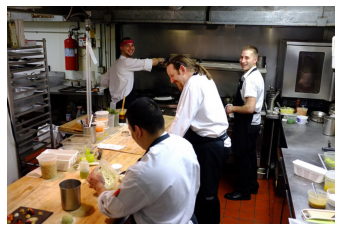

Question : do you see many large pots?
Actual Answer:  no
Top Predicted answers:  [('no', 60.910343), ('yes', 39.08322), ('1', 0.001695636), ('cake', 0.0004217959), ('man', 0.00033896582)]
******************************************************************************************************************************************************


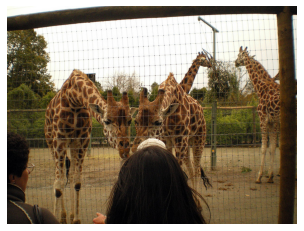

Question : how many giraffes are there?
Actual Answer:  4
Top Predicted answers:  [('2', 40.008907), ('3', 19.363981), ('1', 19.14846), ('4', 13.233789), ('5', 5.574646)]
******************************************************************************************************************************************************


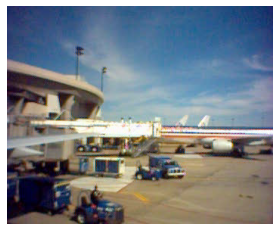

Question : what color is above blue on the plane?
Actual Answer:  white
Top Predicted answers:  [('white', 19.335629), ('red', 17.997404), ('yellow', 17.413769), ('blue', 10.464201), ('green', 9.010303)]
******************************************************************************************************************************************************


In [0]:
model.load_weights(modelsDirectory + ModelName + "/best.hdf5")
test_idx = np.random.randint(len(X_val), size = 3)
model_vgg = VGG19_Top()
k = 5

for idx in test_idx:
    test_image_id = X_val['image_id'].values[idx]
    test_question = X_val['question'].values[idx]
    actual_answer = X_val['multiple_choice_answer'].values[idx]
    test_image_path = imageDirectory + 'COCO_train2014_' + '%012d.jpg' % (test_image_id)

    test_image_features = model_vgg(tf.expand_dims(load_image(test_image_path)[0], 0))
    test_question_features = tf.keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([test_question]),padding='post',
                                                                           maxlen=question_vector_train.shape[1])
    y_pred = model.predict([test_image_features,test_question_features])

    class_indices = tf.math.top_k(y_pred,k=k).indices.numpy()
    percentages = tf.math.top_k(y_pred,k=k).values.numpy()[0] * 100
    predictions = []
    for idx,i in enumerate(class_indices[0]):
        classes = np.zeros((1,1000))
        classes[0][i] = 1
        predictions.append((label_encoder.inverse_transform(classes)[0],percentages[idx]))

    img=mpimg.imread(test_image_path)
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()

    print("Question :", test_question.replace("<start> ","").replace(" <end>",""))
    print("Actual Answer: ", actual_answer)
    print("Top Predicted answers: ",predictions)
    print("*"*150)